# **HW1** 

## **Part 1: Onion vs. Economist**

### Import Libraries

In [106]:
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Cleaning the texts
import re
import nltk
nltk.download('stopwords') # dictionary contains all stopping words
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 

# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mengh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preparation

In [116]:
econ_path = 'C:/Users/mengh/Dropbox/FRE-7871-News-Analytics-and-Machine-Learning/HW1/economist/'
onion_path = 'C:/Users/mengh/Dropbox/FRE-7871-News-Analytics-and-Machine-Learning/HW1/onion/'

def data_preparation(path, class_name):

    # Create Dictionary for File Name and Text
    file_name_and_text = {}
    
    if class_name == 'econ':
        sub_path_names = os.listdir(path)
        for sub_path in sub_path_names:        
            file_names = os.listdir(path+sub_path)
            for file in file_names:
                if file.endswith(".txt"):
                    with open(path + sub_path + '/'+ file, "r") as target_file:
                         file_name_and_text[file] = target_file.read()
    else:
        file_names = os.listdir(path)
        for file in file_names:
            if file.endswith(".txt"):
                with open(path + file, "r") as target_file:
                     file_name_and_text[file] = target_file.read()

    file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
                 .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))
    file_data['class'] = class_name
    return file_data

def data_generate_label(df):
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    df = df.astype({'class': int})
    
    return df

econ_df = data_preparation(econ_path, 'econ')
onion_df = data_preparation(onion_path, 'onion')
article_df = pd.concat([econ_df, onion_df], ignore_index=True)

article_df = data_generate_label(article_df)
article_df.head()

,file_name,text,class
0,africa.1.txt,\n ...,0
1,africa.10.txt,\n ...,0
2,africa.11.txt,\n The Kurds say they still want more of it ...,0
3,africa.12.txt,\n A politician who paid the price for telli...,0
4,africa.13.txt,\n President Mwai Kibaki is loth to back dow...,0


### Data Cleaning 

In [139]:
def data_cleaning(article_df):
    corpus = [] # bag of words
    
    for index, row in article_df.iterrows():
        article = re.sub('[^a-zA-Z]', ' ', row['text']) # keep only letters
        article = article.lower() # lower case 
        article = article.split() # string to list 
        ps = PorterStemmer() # sstemmed

        article = [ps.stem(word) for word in article if not word in set(stopwords.words('english'))] # if not stopping word, reserve word 
        article = ' '.join(article) # list to string 
        corpus.append(article)
        if (int(index)+1) % 50 == 0:
            print('{} articles cleaned...'.format(int(index)+1))
    print('complete.') 
    return corpus

### Model Testing
+ Evaluate classifier using 10-fold cross validation and report overall prediction **accuracy**, **precision**, **recall** and **F1** of each class for the ***validataion set***.
+ Summarize error metrices for each class and confusion matrix for the ***test set***.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=11000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
=======Performance Metrics for Validation Set=============
  Model  ValAccuracy  ValPrecision  ValRecall  ValF1Score
0    NB     0.989655      0.990265   0.989655    0.989787

=======Performance Metrics for Test Set=============
              precision    recall  f1-score   support

        econ     0.9810    0.9717    0.9763       106
       onion     0.9250    0.9487    0.9367        39

   micro avg     0.9655    0.9655    0.9655       145
   macro avg     0.9530    0.9602    0.9565       145
weighted avg     0.9659    0.9655    0.9657       145



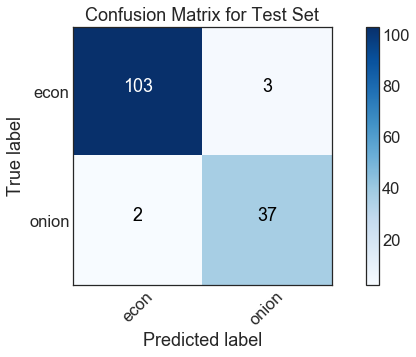

In [102]:
def nlp_model(corpus, article_df, ticker_marks):
    cv = CountVectorizer(max_features = 11000)
    X = cv.fit_transform(corpus).toarray()
    y = article_df.loc[:, 'class'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='weighted'),
           'recall' : make_scorer(recall_score, average='weighted'), 
           'f1_score' : make_scorer(f1_score, average='weighted')}
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_validate(estimator=classifier, X=X_train, y=y_train, cv=kfold, scoring=scoring)
    kfold_performance = pd.DataFrame({'Model': 'NB', 'ValAccuracy': np.mean(results['test_accuracy']),
                                       'ValPrecision': np.mean(results['test_precision']),
                                       'ValRecall': np.mean(results['test_recall']),
                                       'ValF1Score': np.mean(results['test_f1_score'])}, index=[0])

    print('=======Performance Metrics for Validation Set=============')
    print(kfold_performance)
    print()
    print('=======Performance Metrics for Test Set=============')
    print(classification_report(y_test, y_pred, target_names=ticker_marks, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title='Confusion Matrix for Test Set', ticker_marks=ticker_marks)


def plot_confusion_matrix(cm, title='Confusion matrix', ticker_marks=['econ', 'onion'], cmap=plt.cm.Blues):
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-white')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.array(ticker_marks)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(tick_marks)))
    ax.set_xticklabels(tick_marks, rotation=45)
    ax.set_yticks(np.arange(len(tick_marks)))
    ax.set_yticklabels(tick_marks)
#     plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
nlp_model(corpus, article_df, ['econ', 'onion'])

### Performance Analysis

+ We could see that the overall prediction accuracy is very high expecially for *Economist*.
+ We can see that our NB model predicts *Economist* better than *Onion*. The potential reason is that we have much less *Onion* labels in our trainning set, which will make our model difficult to extract most valuable keywords for *Onion* class. 
+ Another reason is that *Economist* is more serious in which the authors are more cautious with words they use, while *Onion* is not so serious, so some of the words are not *accurate* enough. It will incrase the prediction difficulty for *Onion* class.
+ Also we are using *1-Gram* model here which disregards the correlation between words and appply *Navie Bayes* with some unrealistic assumption that features are independent with each other. One potential improvement is to build *N-Gram* model for *bag  of words*.

### Most Frequent Words in Each Class

In [144]:
def word_counter(df):
    corpus = data_cleaning(df)
    corpus = ' '.join(corpus)
    corpus = corpus.split()
    counter = Counter(corpus)
    return counter 

In [145]:
econ_counter = word_counter(econ_df)

50 articles cleaned...
100 articles cleaned...
150 articles cleaned...
200 articles cleaned...
250 articles cleaned...
300 articles cleaned...
350 articles cleaned...
400 articles cleaned...
450 articles cleaned...
500 articles cleaned...
complete.


In [155]:
econ_most_occur = econ_counter.most_common(5) 
econ_least_occur = econ_counter.most_common()[:-6:-1]
print('Most common five words in Economist: ')
print(econ_most_occur)
print()
print('Least common five words in Economist: ')
print(econ_least_occur)

Most common five words in Economist: 
[('mr', 3068), ('year', 1460), ('govern', 1324), ('one', 1231), ('say', 1163)]

Least common five words in Economist: 
[('gin', 1), ('aisl', 1), ('credenc', 1), ('afterlif', 1), ('lott', 1)]


In [152]:
onion_counter = word_counter(onion_df)

50 articles cleaned...
100 articles cleaned...
150 articles cleaned...
complete.


In [157]:
onion_most_occur = onion_counter.most_common(5) 
onion_least_occur = onion_counter.most_common()[:-6:-1]
print('Most common five words in Onion: ')
print(onion_most_occur)
print()
print('Least common five words in Onion: ')
print(onion_least_occur)

Most common five words in Onion: 
[('said', 1135), ('time', 399), ('one', 374), ('year', 330), ('like', 321)]

Least common five words in Onion: 
[('fern', 1), ('width', 1), ('claw', 1), ('courtroom', 1), ('embroid', 1)]


+ We can see that the most common words in both *Economist* and *Onion* classes are not representative of the class. That means our data cleaning function needs to be modified to reduce these common words. 
+ Five words to represent *Economist* class: **economi**, **iraq**, **law**, **tax**, **rule** since usually they could represent some serious topics.

+ Five words to represent *Economist* class: **school**, **good**, **play**, **home**, **famili** since usually they could represent some non-serious topics.

+ I think these selected words are more useful for distinguishing between classes than others.

## **Part 2: Economist Regions**

### Data Preparation

In [98]:
econ_path = 'C:/Users/mengh/Dropbox/FRE-7871-News-Analytics-and-Machine-Learning/HW1/economist/'

def econ_data_preparation(path):
    df = pd.DataFrame(columns=['file_name', 'text', 'class'])  
    region_names = os.listdir(path)

    for region_name in region_names:
        # Create Dictionary for File Name and Text
        file_name_and_text = {}
        file_names = os.listdir(path+region_name)
        for file in file_names:
            if file.endswith(".txt"):
                with open(path + region_name + '/'+ file, "r") as target_file:
                     file_name_and_text[file] = target_file.read()

        file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
                     .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))
        file_data['class'] = region_name 
        
        df =  pd.concat([df, file_data], ignore_index=True)
    
    return df, region_names

econ_df, region_names = econ_data_preparation(econ_path)
econ_df = data_generate_label(econ_df)
econ_df.head()

,file_name,text,class
0,africa.1.txt,\n ...,0
1,africa.10.txt,\n ...,0
2,africa.11.txt,\n The Kurds say they still want more of it ...,0
3,africa.12.txt,\n A politician who paid the price for telli...,0
4,africa.13.txt,\n President Mwai Kibaki is loth to back dow...,0


### Data Cleaning

In [99]:
corpus_econ = data_cleaning(econ_df)

50 articles cleaned...
100 articles cleaned...
150 articles cleaned...
200 articles cleaned...
250 articles cleaned...
300 articles cleaned...
350 articles cleaned...
400 articles cleaned...
450 articles cleaned...
500 articles cleaned...
complete.


### Model Testing

=======Performance Metrics for Validation Set=============
  Model  ValAccuracy  ValPrecision  ValRecall  ValF1Score
0    NB     0.814563      0.849923   0.814563    0.811468

=======Performance Metrics for Test Set=============
               precision    recall  f1-score   support

       africa     0.9444    0.9444    0.9444        18
         asia     0.9231    0.9231    0.9231        13
      britain     0.7241    0.9545    0.8235        22
       europe     0.8333    0.8333    0.8333        18
international     0.3333    0.2222    0.2667         9
latin_america     0.9333    0.9333    0.9333        15
north_america     1.0000    0.6667    0.8000        12

    micro avg     0.8318    0.8318    0.8318       107
    macro avg     0.8131    0.7825    0.7892       107
 weighted avg     0.8311    0.8318    0.8235       107



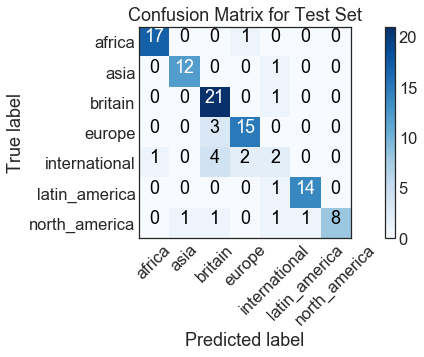

In [100]:
nlp_model(corpus_econ, econ_df, region_names)

### Performance Analysis

+ We could see that the overall prediction accuracy is very high expecially for *north_america*.
+ We can see our model can predict some classes better than the others. The potential reason is that some some class may contain less labels than the other, which causes the data imbalance problem and make some class feature not extracted accurate enough. 
+ We can see *britian* prediction is the least accurate one since it has some common feature with *europe* and *international* which makes it a little hard to distinguish.
+ Most frequent words process could be similar to Part 1, which means most common words do not mean most representative. Our word cleaning process need to be improved to select informative words, otherwise we just add so such noise to make our classification problem hard. More smart way to choose representative information need to be applied. Least common words sometimes contain much more useful information. 